In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings('ignore')

**В качестве временного ряда для исследований возьму данные о количестве вооруженных ограблений в Бостоне по месяцам**

In [2]:
path = 'C:\\Users\\79111\\Notebooks\\11. Временные ряды\\1._Лекция_tsml\\Series\\'
series = np.array(pd.read_csv(path+"monthly-boston-armed-robberies-j.csv")['Count'])

# 1. ARIMA

In [3]:
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(ts, lags=30):
    test_stationarity(ts)
    if not isinstance(ts, pd.Series):
        ts = pd.Series(ts)
    with plt.style.context('bmh'):
        plt.figure(figsize=(16,8))
        ts_ax = plt.subplot2grid((5, 1), (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid((5, 1), (2, 0))
        pacf_ax = plt.subplot2grid((5, 1), (3, 0))
        qq_ax = plt.subplot2grid((5, 1), (4, 0))

        ts.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(ts, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(ts, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(ts, line='s', ax=qq_ax)

        plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


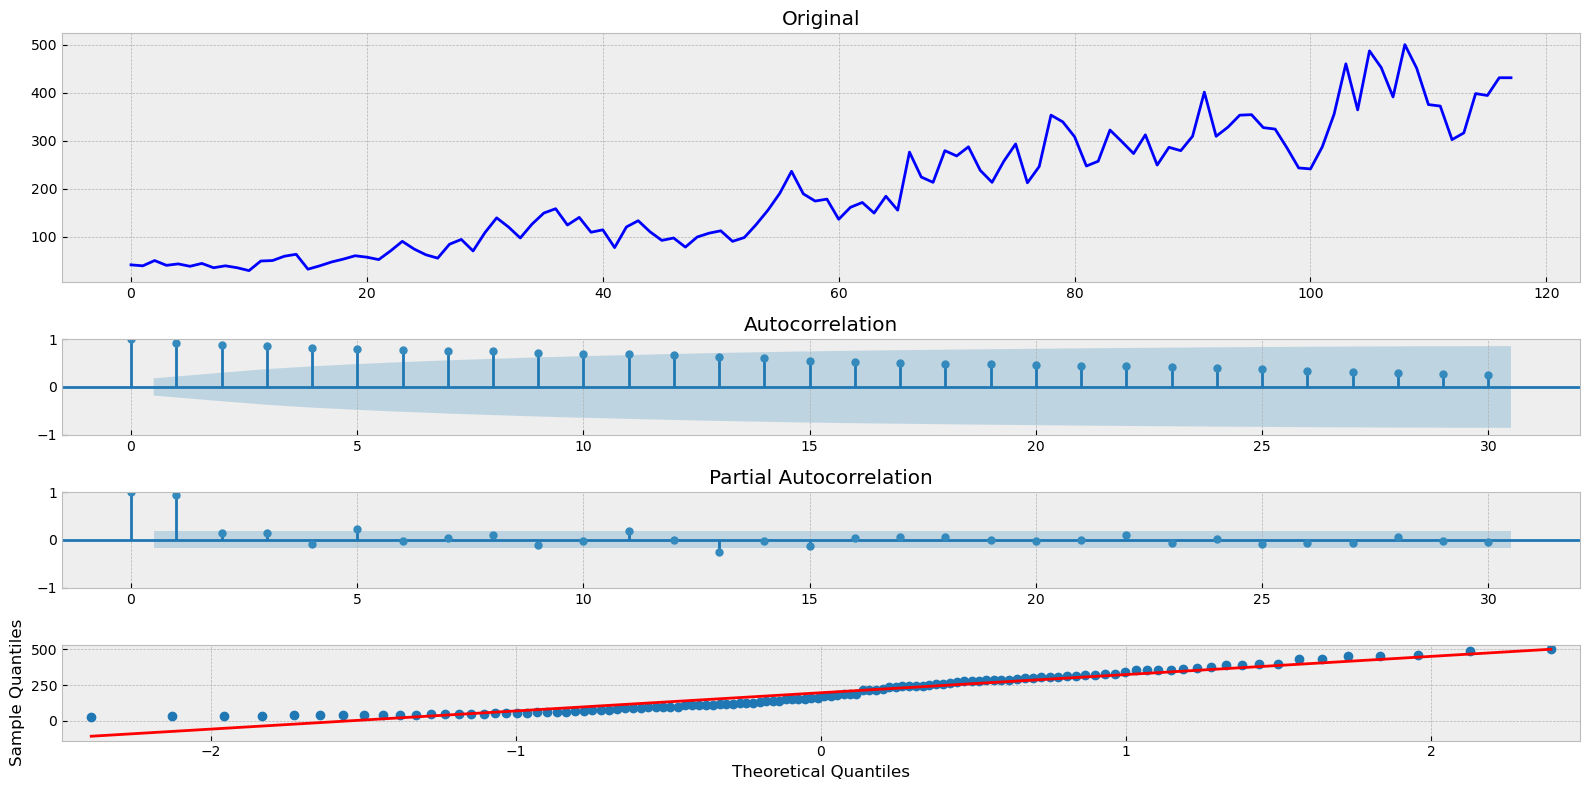

In [5]:
tsplot(series)

**Как видно, график нестационарный, у него растет дисперсия, есть тренд, но, похоже отсутствует сезонность. Разделю данные на тренировочные и тестовые. Для тестирования моделей оставлю 10 последних значений - их я не буду показывать при обучении**

In [6]:
train, test = series[:-10], series[-10:]

**Для подбора гиперпараметров `p d q` для модели ARIMA запущу вложенные циклы. Для каждого параметра искать буду значения в диапазоне от 0 до 5. Модель с наименьшим критерием Акаике буду использовать для прогнозирования**

In [7]:
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order = None
best_model = None

for p in range(6):
    for d in range(6):
        for q in range(6):
            try:
                model = ARIMA(train, order=(p, d, q), trend='ct').fit()
                if model.aic < best_aic:
                    best_model, best_aic, best_order = model, model.aic, (p, d, q)
                if best_model == model:
                    print('best aic:', best_aic, 'best order:', best_order)
            except:
                continue

best aic: 1120.3242183079903 best order: (0, 0, 0)
best aic: 1090.563705335531 best order: (0, 0, 1)
best aic: 1087.415207359706 best order: (0, 0, 2)
best aic: 1084.5921638104567 best order: (0, 0, 3)
best aic: 1083.4714705001136 best order: (0, 0, 5)
best aic: 1080.5894709753513 best order: (1, 0, 0)
best aic: 1079.0144330921455 best order: (2, 0, 5)


Results of Dickey-Fuller Test:
Test Statistic                -1.053418e+01
p-value                        8.989966e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.070000e+02
Critical Value (1%)           -3.492996e+00
Critical Value (5%)           -2.888955e+00
Critical Value (10%)          -2.581393e+00
dtype: float64


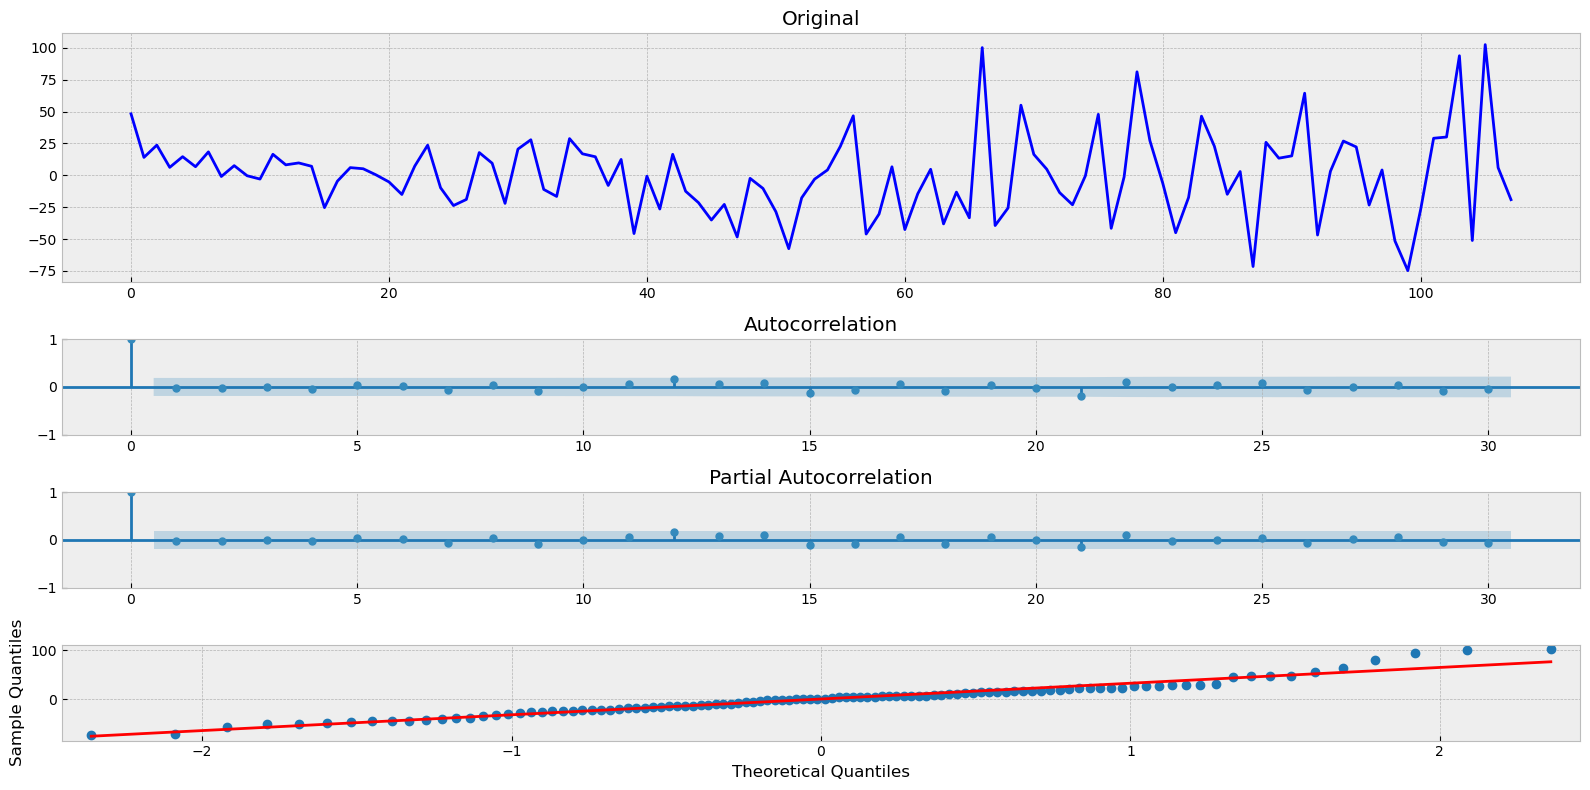

In [8]:
tsplot(best_model.resid)

**График остатков стационарный, это видно по результатам теста Дики-Фуллера и по графикам автокорреляции. На остатках все еще заметен рост дисперсии, но это нормально, поскольку я не применял метод Бокса-Кокса ко временному ряду**

**Теперь на основе полученной модели построю график прогноза и сравню его с отложенными тестовыми данными**

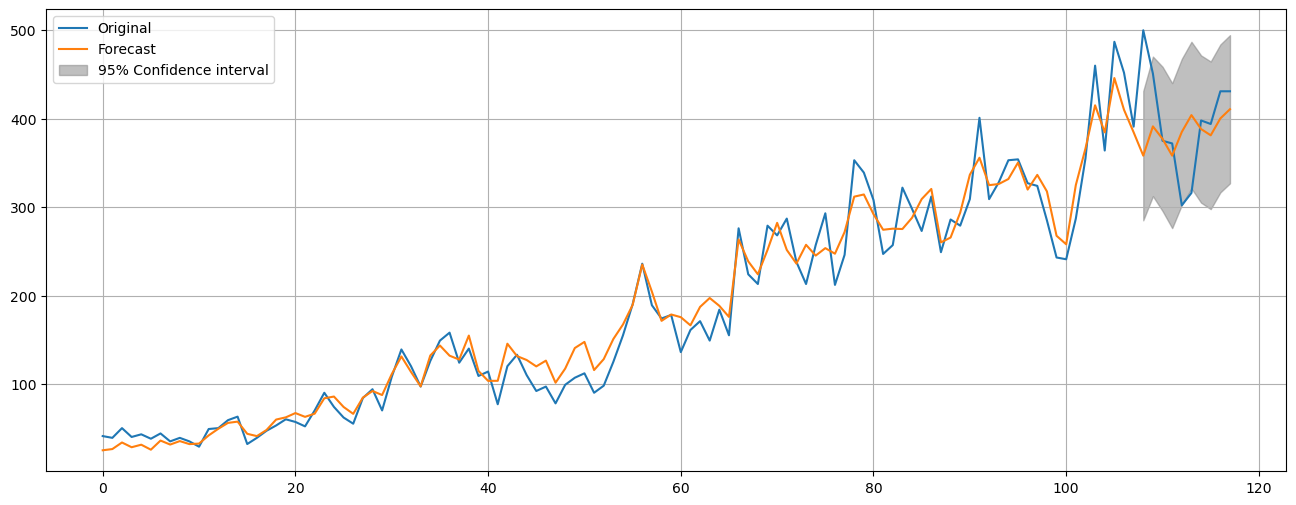

In [9]:
forecast = best_model.get_prediction(start=1, end=len(series))

plt.figure(figsize=(16,6))
plt.plot(series, label='Original')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(x=range(len(train),len(series)),
                 y1=forecast.conf_int()[-10:,0],
                 y2=forecast.conf_int()[-10:,1],
                 alpha=0.5, color='gray', label='95% Confidence interval')
plt.grid()
plt.legend();

**Посчитаю насколько сильно в среднем полученная модель ошибается в процентном выражении при обучении и на тесте**

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

train_mape = mean_absolute_percentage_error(train, forecast.predicted_mean[:-10])
test_mape = mean_absolute_percentage_error(test, forecast.predicted_mean[-10:])

print('MAPE на обучении:', train_mape)
print('MAPE на тесте:', test_mape)

MAPE на обучении: 0.12012713029745116
MAPE на тесте: 0.11877225866932059


**На мой взгляд получилось весьма неплохо, на тестовых данных модель показала результат даже чуть лучше, чем при обучении. Все же надо учитывать, что прогнозная способность такой модели не может быть достаточно хорошей для долгосрочного прогнозирования**

# 2. ML подход

**Теперь попробую обучить модель линейной регрессии. Для прогноза следующего значения ряда в качестве признаков буду использовать 5 предыдущих значений, их среднее арифметическое и тренд. Таким образом я сформирую датасет из обучающей выборки, чтобы на нем потом обучить регрессию**

In [11]:
df = pd.DataFrame({'avg': [], 'trend': [], 't-5': [], 't-4': [], 't-3': [], 't-2': [], 't-1': [], 'target': []})

for i in range(5, len(train)):
    t_s = list(train[i-5:i])
    avg = np.mean(t_s)
    trend = (t_s[-1] - t_s[0]) / t_s[0]
    df.loc[i] = [avg, trend] + t_s + [train[i]]

df.head()

,avg,trend,t-5,t-4,t-3,t-2,t-1,target
5,42.6,0.048780,41.0,39.0,50.0,40.0,43.0,38.0
6,42.0,-0.025641,39.0,50.0,40.0,43.0,38.0,44.0
7,43.0,-0.120000,50.0,40.0,43.0,38.0,44.0,35.0
8,40.0,-0.125000,40.0,43.0,38.0,44.0,35.0,39.0
9,39.8,-0.093023,43.0,38.0,44.0,35.0,39.0,35.0


In [12]:
from sklearn.linear_model import Ridge

X = df.drop('target', axis=1)
y = df.target

model = Ridge(alpha=10)
model.fit(X, y)

Ridge(alpha=10)

**Теперь для построения прогноза в уже обученную модель я буду подавать по одному объекту, состоящему из пяти предыдущих значений, их среднего и тренда. Предсказание модели буду записывать следующим значением, и затем его же включать в следующий объект как предыдущее. Я проделаю это для наблюдений из тестовой выборки, чтобы затем сравнить с реальными данными**

In [13]:
for i in range(len(train), len(series)+1):
    t_s = list(df.iloc[-1,-5:].values)
    avg = np.mean(t_s)
    trend = (t_s[-1] - t_s[0]) / t_s[0]
    X = [avg, trend] + t_s
    target = model.predict([X])
    df.loc[i] = X + list(target)

df.tail()

,avg,trend,t-5,t-4,t-3,t-2,t-1,target
114,439.584152,0.053697,425.251364,435.126545,448.236363,441.220232,448.086255,451.874043
115,444.908688,0.038489,435.126545,448.236363,441.220232,448.086255,451.874043,454.125026
116,448.708384,0.013137,448.236363,441.220232,448.086255,451.874043,454.125026,460.049467
117,451.071005,0.042675,441.220232,448.086255,451.874043,454.125026,460.049467,462.963007
118,455.419560,0.033201,448.086255,451.874043,454.125026,460.049467,462.963007,466.599289


**Теперь построю график прогноза и сравню его с отложенными тестовыми данными. Еще раз отмечу, что последние 10 значений на графике - это прогноз модели, основанный на ее последовательных предсказаниях. Предыдущие значения - это прогноз модели на данных, которые ранее уже были использованы для ее обучения**

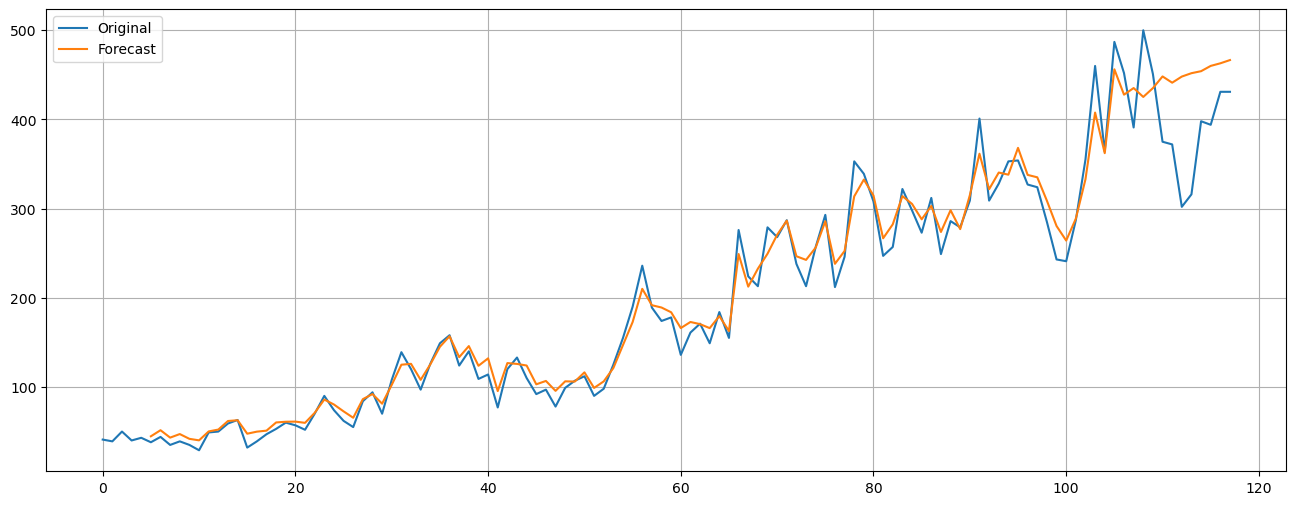

In [14]:
forecast = model.predict(df.drop('target', axis=1))[1:]

plt.figure(figsize=(16,6))
plt.plot(series, label='Original')
plt.plot(range(5,len(series)), forecast, label='Forecast')
plt.grid()
plt.legend();

**Посчитаю насколько сильно в среднем полученная модель ошибается в процентном выражении при обучении и на тесте**

In [15]:
train_mape = mean_absolute_percentage_error(train[5:], forecast[:-10])
test_mape = mean_absolute_percentage_error(test, forecast[-10:])

print('MAPE на обучении:', train_mape)
print('MAPE на тесте:', test_mape)

MAPE на обучении: 0.08494707531005659
MAPE на тесте: 0.19451896955978407


**Видно, что получившаяся модель линейной регрессии дает на тесте предсказания значительно хуже (`MAPE = 0.195`), чем ARIMA (`MAPE = 0.119`). При этом на обучении у регрессии ошибка меньше (`MAPE = 0.085`), чем у ARIMA (`MAPE = 0.12`). Это может говорить о том, что линейная регрессия переобучилась на тренировочных данных. Дополнительно, ARIMA учитывает в прогнозе ошибку на предыдущих предсказаниях, чего не делает моя линейная регрессия, и это тоже идет в минус к ее точности**